In [1]:
# 설비 이상 유무 파악 -> 회귀분석 필요 X
# y 가 없다 x로 y만들어서 영향을 주는 거 찾는다 
# 시간데이터 있음 -> 설비이상이 발생하는 특정 주기 파악 가능 ex) 오전, 오후, 새벽, 
#  연속형 변수 많음 -> 이상여부y값 만들어 내야함 어떻게? 
# y를 0(정상) 1(이상)으로 만들자 어떻게?
# 어제한것에 정답이 있다.
# 각 x변수중 튀는기준을 어떻게 볼것인가 with IQR
# 기준을 잡아야해 at 연속형 data에 각 x인자를 가지고 +_30 벗어나는값 counting가능 각 x에 누적합을 해서 x 변수 벗어나는 값 counting -> 

# 행단위 계산 후 Iqr넘어가면 파생변수 X1 -> p > 1 => 1 or 0
# 해서 1 값들을 sum
# sum한 값들을 기준으로 n개 이상 넘어가면 얘는 고장!(1)
# counting값 기준으로 
# x(inputs)값들 기준으로 이상치 넘어가는거 갯수 파악해서 3개이상 넘어가면 이상치 ex)


## 설비이상 유무 파악
### 

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
# 데이터 분할
from sklearn.model_selection import train_test_split
# qq plot , 회귀분석 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형모델
import statsmodels.formula.api as smf
# 평가함수
from statsmodels.tools.eval_measures import rmse
# 결정계수 평가지표
from sklearn.metrics import r2_score
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
matplotlib.rc('font',family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [47]:
# 데이터 불러오기
df = pd.read_csv('machine.csv')
df.head()

,Process_Type,Datetime,Code_Num,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,Tube_Furnace_CP,Tube_Furnace1_Temp,Tube_Furnace2_Temp,Tube_Furnace3_Temp,Tube_Furnace4_Temp
0,OP-A,2022-01-03 11:22,GroupA,NaN,75.6648,NaN,73.527404,59.989422,52.249481,72.134908,0.450497,NaN,868.759544,NaN,NaN
1,OP-A,2022-01-03 11:22,GroupA,NaN,75.6706,NaN,79.149174,62.027232,50.617109,71.245235,0.457370,878.116929,883.821264,890.740760,894.430606
2,OP-A,2022-01-03 11:22,GroupA,99.614201,75.6776,68.724636,78.946336,62.235532,52.218350,72.705558,0.454914,866.441979,882.850031,864.373065,893.530501
3,OP-A,2022-01-03 11:22,GroupA,99.376221,75.8656,69.161116,78.445719,61.608260,52.863552,73.975640,0.456540,876.350472,906.208463,891.107865,896.347636
4,OP-C,2022-01-03 11:22,GroupA,99.809053,73.6468,69.181098,76.673808,61.589311,52.297196,71.887865,0.460100,903.587678,867.215131,893.206883,871.594283


In [48]:
# data 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231123 entries, 0 to 231122
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Process_Type        231123 non-null  object 
 1   Datetime            231123 non-null  object 
 2   Code_Num            231123 non-null  object 
 3   Z1_Temp             231098 non-null  float64
 4   Z1_OP1              231123 non-null  float64
 5   ST                  231098 non-null  float64
 6   Tube_Furnace1_OP    230869 non-null  float64
 7   Tube_Furnace2_OP    231123 non-null  float64
 8   Tube_Furnace3_OP    231123 non-null  float64
 9   Tube_Furnace4_OP    231123 non-null  float64
 10  Tube_Furnace_CP     231123 non-null  float64
 11  Tube_Furnace1_Temp  231118 non-null  float64
 12  Tube_Furnace2_Temp  231113 non-null  float64
 13  Tube_Furnace3_Temp  231114 non-null  float64
 14  Tube_Furnace4_Temp  231108 non-null  float64
dtypes: float64(12), object(3)
memory u

In [59]:
df.describe()

,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,Tube_Furnace_CP,Tube_Furnace1_Temp,Tube_Furnace2_Temp,Tube_Furnace3_Temp,Tube_Furnace4_Temp
count,231098.000000,231123.000000,231098.000000,230869.000000,231123.000000,231123.000000,231123.000000,231123.000000,231118.000000,231113.000000,231114.000000,231108.000000
mean,100.509681,72.622572,69.092959,75.309558,47.572004,50.532954,70.247528,0.449687,884.538184,885.041544,885.025677,884.987706
std,0.427198,3.009119,1.078253,20.663091,4.413487,1.965125,2.281762,0.044180,14.605636,14.418405,14.439180,14.431341
min,98.370946,52.981600,64.991438,0.005366,35.201679,37.519408,56.748502,0.097992,848.284519,858.669661,858.665411,858.352659
25%,100.234014,71.319050,68.253179,68.880077,45.219167,49.419740,68.875604,0.451953,872.057405,872.561376,872.534710,872.527927
50%,100.506511,72.903600,69.084741,78.708391,46.734401,50.646872,70.269142,0.454912,884.527439,885.047402,885.057021,884.954480
75%,100.779431,74.405000,69.996097,87.697873,48.412866,51.799096,71.554405,0.457826,896.960869,897.537632,897.535983,897.440629
max,102.663995,84.591100,71.527025,100.999998,66.825322,59.490855,83.410766,0.916338,920.832651,911.358760,910.976126,911.762271


In [60]:
df.isnull().sum()

Process_Type            0
Datetime                0
Code_Num                0
Z1_Temp                25
Z1_OP1                  0
ST                     25
Tube_Furnace1_OP      254
Tube_Furnace2_OP        0
Tube_Furnace3_OP        0
Tube_Furnace4_OP        0
Tube_Furnace_CP         0
Tube_Furnace1_Temp      5
Tube_Furnace2_Temp     10
Tube_Furnace3_Temp      9
Tube_Furnace4_Temp     15
dtype: int64

In [112]:
np.mean(df['Tube_Furnace1_OP'])

75.3132929761873

In [114]:
# 결측치 평균으로 바꾸자 4분위 사이에 큰 차이가 없으니
df['Z1_Temp'] = df['Z1_Temp'].fillna(df['Z1_Temp'].median())
df.head()

,Process_Type,Datetime,Code_Num,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,Tube_Furnace_CP,Tube_Furnace1_Temp,Tube_Furnace2_Temp,Tube_Furnace3_Temp,Tube_Furnace4_Temp,Z1_Temp_p
0,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6648,69.084741,73.527404,59.989422,52.249481,72.134908,0.450497,884.527439,868.759544,885.057021,884.954480,0
1,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6706,69.084741,79.149174,62.027232,50.617109,71.245235,0.457370,878.116929,883.821264,890.740760,894.430606,0
2,OP-A,2022-01-03 11:22,GroupA,99.614201,75.6776,68.724636,78.946336,62.235532,52.218350,72.705558,0.454914,866.441979,882.850031,864.373065,893.530501,0
3,OP-A,2022-01-03 11:22,GroupA,99.376221,75.8656,69.161116,78.445719,61.608260,52.863552,73.975640,0.456540,876.350472,906.208463,891.107865,896.347636,0
4,OP-C,2022-01-03 11:22,GroupA,99.809053,73.6468,69.181098,76.673808,61.589311,52.297196,71.887865,0.460100,903.587678,867.215131,893.206883,871.594283,0


In [116]:
df['ST'] = df['ST'].fillna(df['ST'].median())
df['Tube_Furnace1_OP'] = df['Tube_Furnace1_OP'].fillna(df['Tube_Furnace1_OP'].median())
df['Tube_Furnace1_Temp'] = df['Tube_Furnace1_Temp'].fillna(df['Tube_Furnace1_Temp'].median())
df['Tube_Furnace2_Temp'] = df['Tube_Furnace2_Temp'].fillna(df['Tube_Furnace2_Temp'].median())
df['Tube_Furnace3_Temp'] = df['Tube_Furnace3_Temp'].fillna(df['Tube_Furnace3_Temp'].median())
df['Tube_Furnace4_Temp'] = df['Tube_Furnace4_Temp'].fillna(df['Tube_Furnace4_Temp'].median())

# 결측치 평균으로 바꾸기

In [118]:
df.isnull().sum()

Process_Type          0
Datetime              0
Code_Num              0
Z1_Temp               0
Z1_OP1                0
ST                    0
Tube_Furnace1_OP      0
Tube_Furnace2_OP      0
Tube_Furnace3_OP      0
Tube_Furnace4_OP      0
Tube_Furnace_CP       0
Tube_Furnace1_Temp    0
Tube_Furnace2_Temp    0
Tube_Furnace3_Temp    0
Tube_Furnace4_Temp    0
Z1_Temp_p             0
dtype: int64

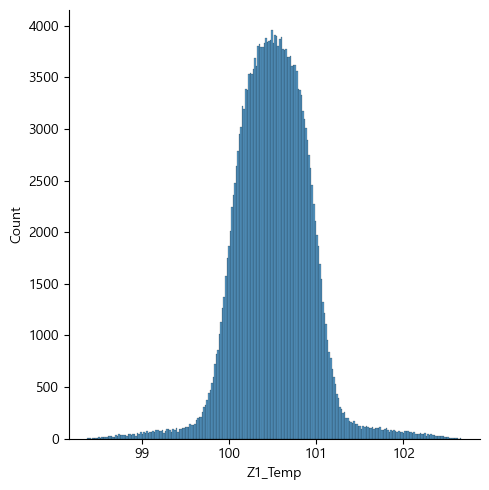

In [120]:
sns.displot(df, x = 'Z1_Temp');

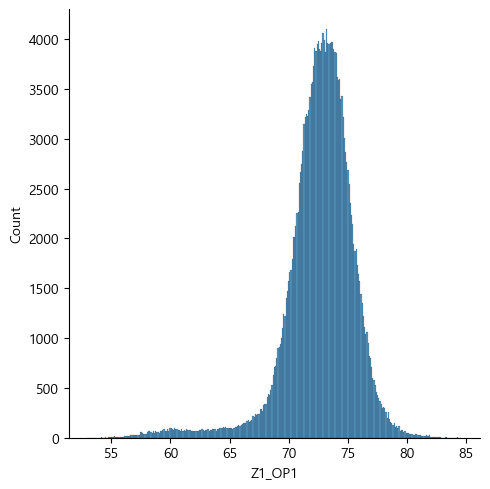

In [122]:
sns.displot(df, x = 'Z1_OP1');

In [94]:
# y값 만들어 보자
# 각 행별로 이상치들을 찾아서 count한 뒤에 더하자
# 그럼 boxplot 부터?
# boxplot 그리려면 결국 y값이 있어야하네


# Z1_Temp_mean = df['Z1_Temp'].mean()
# Z1_Temp_3sigma = df['Z1_Temp'].std()*3

# df['Z1_Temp_p'] = 0
# df.loc[(df['Z1_Temp'] > =  Z1_Temp_mean + Z1_Temp_3sigma) & (df['Z1_Temp'] <=  Z1_Temp_mean - Z1_Temp_3sigma),'Z1_Temp_p'] =1



In [108]:
# Z1_Temp_mean = df['Z1_Temp'].mean()
# Z1_Temp_3sigma = df['Z1_Temp'].std()*3
# df['Z1_Temp_p'] = 0
# df.loc[(df['Z1_Temp'] >=  Z1_Temp_mean + Z1_Temp_3sigma) & (df['Z1_Temp'] <=  Z1_Temp_mean - Z1_Temp_3sigma),'Z1_Temp_p'] =1

# df['Z1_Temp_p'].value_counts()

In [124]:
df.head()

,Process_Type,Datetime,Code_Num,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,Tube_Furnace_CP,Tube_Furnace1_Temp,Tube_Furnace2_Temp,Tube_Furnace3_Temp,Tube_Furnace4_Temp,Z1_Temp_p
0,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6648,69.084741,73.527404,59.989422,52.249481,72.134908,0.450497,884.527439,868.759544,885.057021,884.954480,0
1,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6706,69.084741,79.149174,62.027232,50.617109,71.245235,0.457370,878.116929,883.821264,890.740760,894.430606,0
2,OP-A,2022-01-03 11:22,GroupA,99.614201,75.6776,68.724636,78.946336,62.235532,52.218350,72.705558,0.454914,866.441979,882.850031,864.373065,893.530501,0
3,OP-A,2022-01-03 11:22,GroupA,99.376221,75.8656,69.161116,78.445719,61.608260,52.863552,73.975640,0.456540,876.350472,906.208463,891.107865,896.347636,0
4,OP-C,2022-01-03 11:22,GroupA,99.809053,73.6468,69.181098,76.673808,61.589311,52.297196,71.887865,0.460100,903.587678,867.215131,893.206883,871.594283,0


In [127]:
df = df.drop(['Z1_Temp_p'] , axis = 1)

In [171]:
df.head()

,Process_Type,Datetime,Code_Num,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,Tube_Furnace_CP,Tube_Furnace1_Temp,Tube_Furnace2_Temp,Tube_Furnace3_Temp,Tube_Furnace4_Temp
0,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6648,69.084741,73.527404,59.989422,52.249481,72.134908,0.450497,884.527439,868.759544,885.057021,884.954480
1,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6706,69.084741,79.149174,62.027232,50.617109,71.245235,0.457370,878.116929,883.821264,890.740760,894.430606
2,OP-A,2022-01-03 11:22,GroupA,99.614201,75.6776,68.724636,78.946336,62.235532,52.218350,72.705558,0.454914,866.441979,882.850031,864.373065,893.530501
3,OP-A,2022-01-03 11:22,GroupA,99.376221,75.8656,69.161116,78.445719,61.608260,52.863552,73.975640,0.456540,876.350472,906.208463,891.107865,896.347636
4,OP-C,2022-01-03 11:22,GroupA,99.809053,73.6468,69.181098,76.673808,61.589311,52.297196,71.887865,0.460100,903.587678,867.215131,893.206883,871.594283


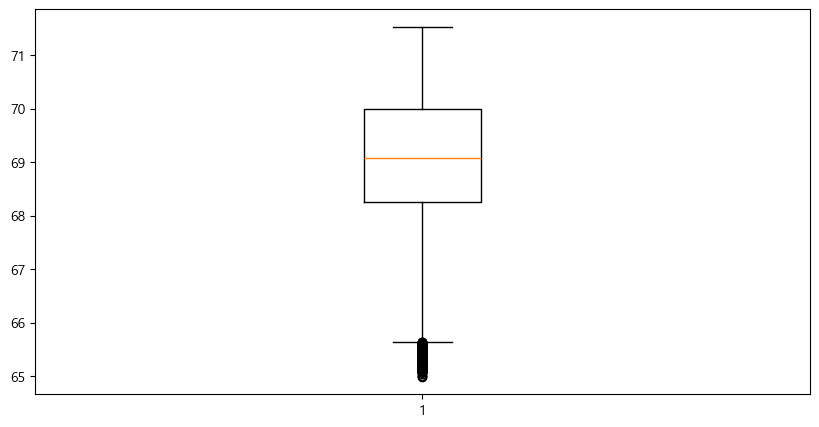

In [258]:
plt.figure(figsize = (10, 5))
plt.boxplot(df['ST'])
plt.show()

In [264]:
df['ST'] <= 67

0         False
1         False
2         False
3         False
4         False
          ...  
231118    False
231119    False
231120    False
231121    False
231122    False
Name: ST, Length: 231123, dtype: bool

<Axes: >

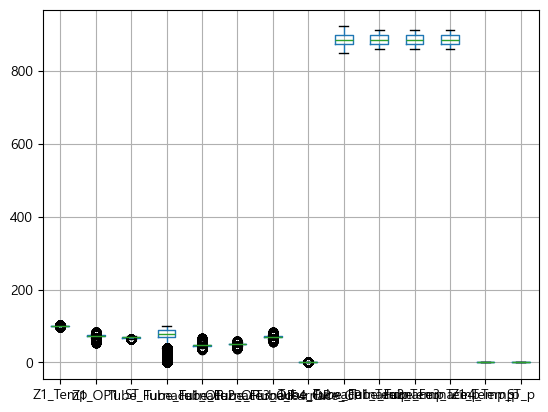

In [241]:
df_num.boxplot()

In [211]:
df_num = df.drop(['Process_Type', 'Datetime' , 'Code_Num'] , axis = 1)
df_num_columns = df_num.columns
df_num_columns

Index(['Z1_Temp', 'Z1_OP1', 'ST', 'Tube_Furnace1_OP', 'Tube_Furnace2_OP',
       'Tube_Furnace3_OP', 'Tube_Furnace4_OP', 'Tube_Furnace_CP',
       'Tube_Furnace1_Temp', 'Tube_Furnace2_Temp', 'Tube_Furnace3_Temp',
       'Tube_Furnace4_Temp', 'Z1_Temp_p', 'ST_p'],
      dtype='object')

In [ ]:
# Z1_Temp_mean = df['Z1_Temp'].mean()
# Z1_Temp_3sigma = df['Z1_Temp'].std()*3
# df['Z1_Temp_p'] = 0
# # df.loc[(df['Z1_Temp'] >=  Z1_Temp_mean + Z1_Temp_3sigma) & (df['Z1_Temp'] <=  Z1_Temp_mean - Z1_Temp_3sigma),'Z1_Temp_p'] =1

# # df['Z1_Temp_p'].value_counts()
# for i in df_num:
#     if df.loc[(df['Z1_Temp'] >= Z1_Temp_mean + Z1_Temp_3sigma) 

In [336]:
for i in df_num_columns:
    ST_mean = df[i].mean()
    ST_3sigma = df[i].std()*3
    df[f"{i}_p"] = 0
    df.loc[(df[i] >=  ST_mean + ST_3sigma) | (df[i] <=  ST_mean - ST_3sigma),f"{i}_p"] = 1
        



df['Tube_Furnace2_Temp_p'].value_counts()


Tube_Furnace2_Temp_p
0    231123
Name: count, dtype: int64

In [227]:
df.columns

Index(['Process_Type', 'Datetime', 'Code_Num', 'Z1_Temp', 'Z1_OP1', 'ST',
       'Tube_Furnace1_OP', 'Tube_Furnace2_OP', 'Tube_Furnace3_OP',
       'Tube_Furnace4_OP', 'Tube_Furnace_CP', 'Tube_Furnace1_Temp',
       'Tube_Furnace2_Temp', 'Tube_Furnace3_Temp', 'Tube_Furnace4_Temp',
       'Z1_Temp_p', 'ST_p', 'Z1_OP1_p', 'Tube_Furnace1_OP_p',
       'Tube_Furnace2_OP_p', 'Tube_Furnace3_OP_p', 'Tube_Furnace4_OP_p',
       'Tube_Furnace_CP_p', 'Tube_Furnace1_Temp_p', 'Tube_Furnace2_Temp_p',
       'Tube_Furnace3_Temp_p', 'Tube_Furnace4_Temp_p', 'Z1_Temp_p_p',
       'ST_p_p'],
      dtype='object')

In [231]:
df = df.drop(['Z1_Temp_p_p','ST_p_p' ] , axis = 1)

In [233]:
df.columns

Index(['Process_Type', 'Datetime', 'Code_Num', 'Z1_Temp', 'Z1_OP1', 'ST',
       'Tube_Furnace1_OP', 'Tube_Furnace2_OP', 'Tube_Furnace3_OP',
       'Tube_Furnace4_OP', 'Tube_Furnace_CP', 'Tube_Furnace1_Temp',
       'Tube_Furnace2_Temp', 'Tube_Furnace3_Temp', 'Tube_Furnace4_Temp',
       'Z1_Temp_p', 'ST_p', 'Z1_OP1_p', 'Tube_Furnace1_OP_p',
       'Tube_Furnace2_OP_p', 'Tube_Furnace3_OP_p', 'Tube_Furnace4_OP_p',
       'Tube_Furnace_CP_p', 'Tube_Furnace1_Temp_p', 'Tube_Furnace2_Temp_p',
       'Tube_Furnace3_Temp_p', 'Tube_Furnace4_Temp_p'],
      dtype='object')

In [274]:
df['Z1_Temp_p'].value_counts()

Z1_Temp_p
0    227067
1      4056
Name: count, dtype: int64

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231123 entries, 0 to 231122
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Process_Type          231123 non-null  object 
 1   Datetime              231123 non-null  object 
 2   Code_Num              231123 non-null  object 
 3   Z1_Temp               231123 non-null  float64
 4   Z1_OP1                231123 non-null  float64
 5   ST                    231123 non-null  float64
 6   Tube_Furnace1_OP      231123 non-null  float64
 7   Tube_Furnace2_OP      231123 non-null  float64
 8   Tube_Furnace3_OP      231123 non-null  float64
 9   Tube_Furnace4_OP      231123 non-null  float64
 10  Tube_Furnace_CP       231123 non-null  float64
 11  Tube_Furnace1_Temp    231123 non-null  float64
 12  Tube_Furnace2_Temp    231123 non-null  float64
 13  Tube_Furnace3_Temp    231123 non-null  float64
 14  Tube_Furnace4_Temp    231123 non-null  float64
 15  

In [410]:
columns_to_extract = ['Z1_Temp_p', 'ST_p', 'Z1_OP1_p', 'Tube_Furnace1_OP_p',
       'Tube_Furnace2_OP_p', 'Tube_Furnace3_OP_p', 'Tube_Furnace4_OP_p',
       'Tube_Furnace_CP_p', 'Tube_Furnace1_Temp_p', 'Tube_Furnace2_Temp_p',
       'Tube_Furnace3_Temp_p', 'Tube_Furnace4_Temp_p']
df_p = df[columns_to_extract]
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231123 entries, 0 to 231122
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Z1_Temp_p             231123 non-null  int64
 1   ST_p                  231123 non-null  int64
 2   Z1_OP1_p              231123 non-null  int64
 3   Tube_Furnace1_OP_p    231123 non-null  int64
 4   Tube_Furnace2_OP_p    231123 non-null  int64
 5   Tube_Furnace3_OP_p    231123 non-null  int64
 6   Tube_Furnace4_OP_p    231123 non-null  int64
 7   Tube_Furnace_CP_p     231123 non-null  int64
 8   Tube_Furnace1_Temp_p  231123 non-null  int64
 9   Tube_Furnace2_Temp_p  231123 non-null  int64
 10  Tube_Furnace3_Temp_p  231123 non-null  int64
 11  Tube_Furnace4_Temp_p  231123 non-null  int64
dtypes: int64(12)
memory usage: 21.2 MB


In [412]:
df_p['sums'] = df_p.sum(axis=1)
df_p['sums'].value_counts()

sums
0    204223
1     21519
2      4876
3       435
4        70
Name: count, dtype: int64

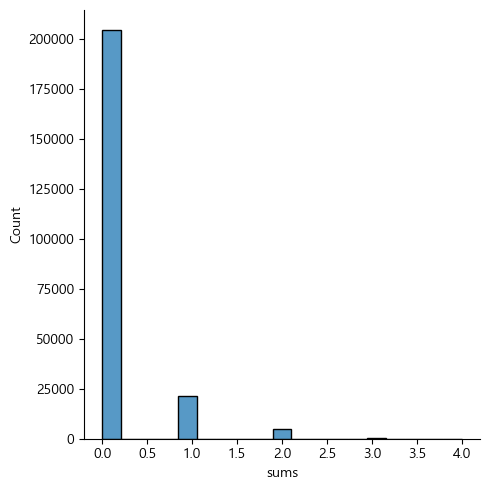

In [414]:
sns.displot(df_p, x = 'sums')

In [416]:
df['sums'] = df_p['sums']
df['sums'].value_counts()

sums
0    204223
1     21519
2      4876
3       435
4        70
Name: count, dtype: int64

In [438]:
# df['sums']의 값이 1 이상이면 0(설비이상) 미만이면 1(설비정상)
df['state'] = df['sums'].apply(lambda x: 0 if x >= 1 else 1)
df['state'].value_counts()

state
1    204223
0     26900
Name: count, dtype: int64

In [440]:
# 0은 설비이상 1은 설비정상

In [442]:
df.head()

,Process_Type,Datetime,Code_Num,Z1_Temp,Z1_OP1,ST,Tube_Furnace1_OP,Tube_Furnace2_OP,Tube_Furnace3_OP,Tube_Furnace4_OP,...,Tube_Furnace4_OP_p,Tube_Furnace_CP_p,Tube_Furnace1_Temp_p,Tube_Furnace2_Temp_p,Tube_Furnace3_Temp_p,Tube_Furnace4_Temp_p,sums,Z1_Temp_p_p,ST_p_p,state
0,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6648,69.084741,73.527404,59.989422,52.249481,72.134908,...,0,0,0,0,0,0,0,0,0,1
1,OP-A,2022-01-03 11:22,GroupA,100.506511,75.6706,69.084741,79.149174,62.027232,50.617109,71.245235,...,0,0,0,0,0,0,1,0,0,0
2,OP-A,2022-01-03 11:22,GroupA,99.614201,75.6776,68.724636,78.946336,62.235532,52.218350,72.705558,...,0,0,0,0,0,0,1,0,0,0
3,OP-A,2022-01-03 11:22,GroupA,99.376221,75.8656,69.161116,78.445719,61.608260,52.863552,73.975640,...,0,0,0,0,0,0,1,0,0,0
4,OP-C,2022-01-03 11:22,GroupA,99.809053,73.6468,69.181098,76.673808,61.589311,52.297196,71.887865,...,0,0,0,0,0,0,1,0,0,0


In [444]:
df_datetime = df[df['state'] == 1]['Datetime']
df_datetime.value_counts()

Datetime
2022-01-15 19:49    60
2022-01-15 16:13    60
2022-01-15 16:07    60
2022-01-12 17:58    60
2022-01-12 17:56    60
                    ..
2022-01-12 23:08     1
2022-01-05 2:07      1
2022-01-14 13:32     1
2022-01-11 0:36      1
2022-01-05 4:42      1
Name: count, Length: 3769, dtype: int64

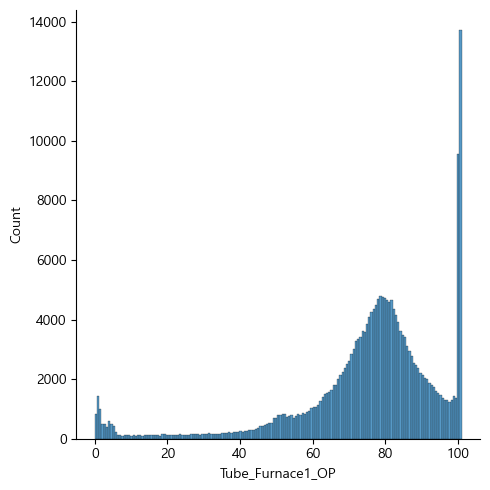

In [446]:
sns.displot(df, x =  'Tube_Furnace1_OP')

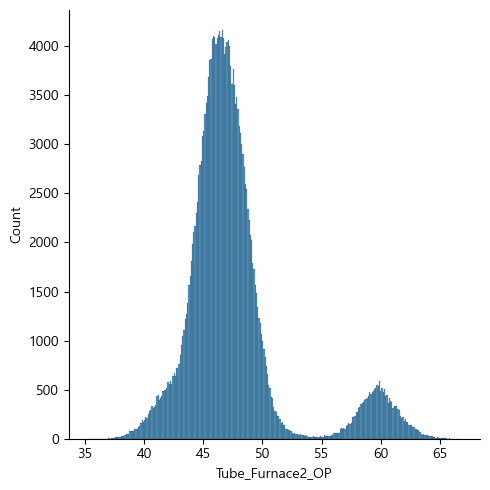

In [447]:
sns.displot(df, x =  'Tube_Furnace2_OP') # 얘는 범주화 해도 될듯?

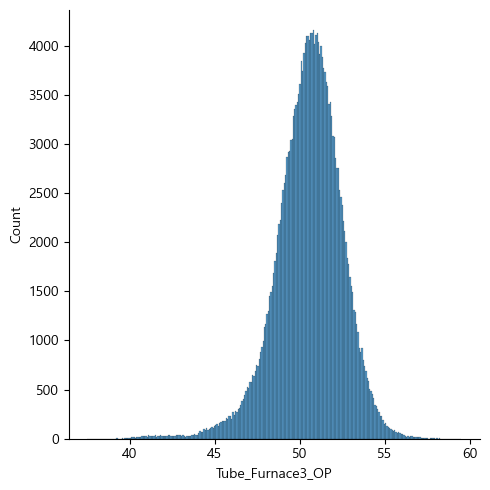

In [448]:
sns.displot(df, x =  'Tube_Furnace3_OP')

<Axes: >

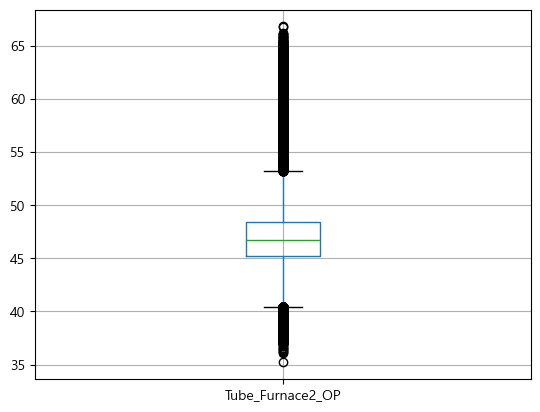

In [450]:
df.boxplot(column = 'Tube_Furnace2_OP')

# 그래프 분석 + 통계검정

## state가 0인거랑 inputs 와 영향을 미치는지

## 2 Sample Ttest
### State가 0 (설비이상)와 Z_1 Temp와의 차이

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import bartlett
from scipy.stats import f_oneway

In [534]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace1_OP값과 이상이 없을 경우의 Tube_Furnace1_OP값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace1_OP값과 이상이 없을 경우의 Tube_Furnace1_OP값에는 평균에 차이가 있다

df1 = df[df['state']  == 0]['Tube_Furnace1_OP']
df2 = df[df['state']  == 1]['Tube_Furnace1_OP']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p}')
# p-value가 0.05보다 작으므로, 대립가설(차이가 있다)
# t 통계량이 음수이므로 Tube_Furnace1_OP의 값이 클수록 이상발생 가능성이 크다

통계량 : 47623.149
p-value : 0.0
2 Sample ttest
t통계량 : -111.194
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace1_OP'>

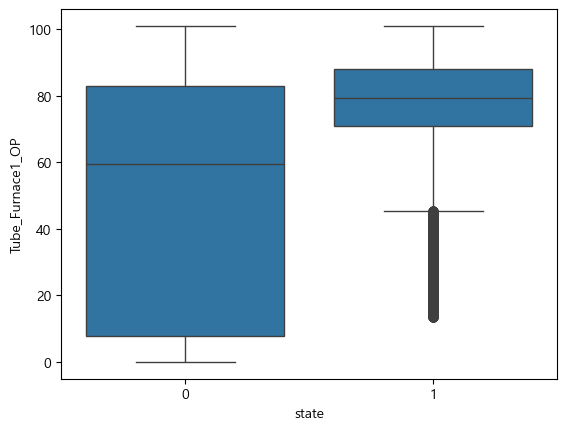

In [536]:
sns.boxplot(x= 'state', y = 'Tube_Furnace1_OP', data = df)

In [532]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace2_OP값과 이상이 없을 경우의 Tube_Furnace2_OP값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace2_OP값과 이상이 없을 경우의 Tube_Furnace2_OP값에는 평균에 차이가 있다

df1 = df[df['state']  == 0]['Tube_Furnace2_OP']
df2 = df[df['state']  == 1]['Tube_Furnace2_OP']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p}')
# p-value가 0.05보다 작으므로, 대립가설(차이가 있다)
# t 통계량이 양수이므로 Tube_Furnace2_OP의 값이 작을수록 이상발생 가능성이 크다

통계량 : 35775.198
p-value : 0.0
2 Sample ttest
t통계량 : 47.451
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace2_OP'>

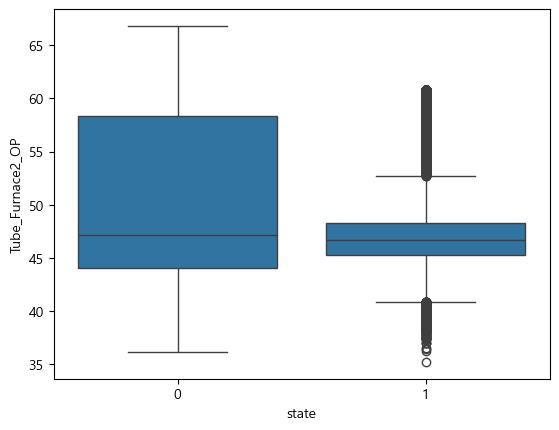

In [538]:
sns.boxplot(x= 'state', y = 'Tube_Furnace2_OP', data = df)

In [540]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace3_OP값과 이상이 없을 경우의 Tube_Furnace3_OP값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace3_OP값과 이상이 없을 경우의 Tube_Furnace3_OP값에는 평균에 차이가 있다
df1 = df[df['state']  == 0]['Tube_Furnace3_OP']
df2 = df[df['state']  == 1]['Tube_Furnace3_OP']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p}')

# p-value가 0.05보다 작으므로, 대립가설(차이가 있다)
# t 통계량이 음수이므로 Tube_Furnace3_OP의 값이 클수록 이상발생 가능성이 크다

통계량 : 26460.777
p-value : 0.0
2 Sample ttest
t통계량 : -46.87
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace3_OP'>

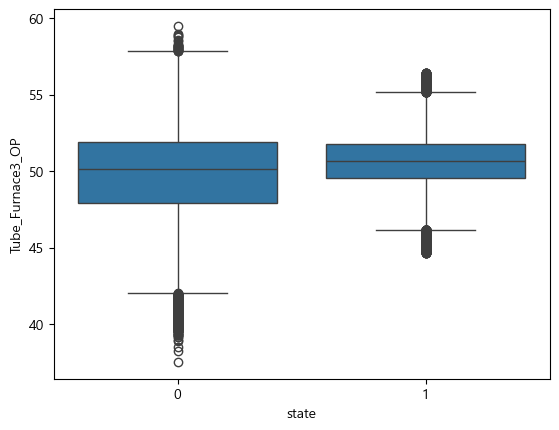

In [542]:
sns.boxplot(x= 'state', y = 'Tube_Furnace3_OP', data = df)

In [580]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace4_OP값과 이상이 없을 경우의 Tube_Furnace4_OP값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace4_OP값과 이상이 없을 경우의 Tube_Furnace4_OP값에는 평균에 차이가 있다
df1 = df[df['state']  == 0]['Tube_Furnace4_OP']
df2 = df[df['state']  == 1]['Tube_Furnace4_OP']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p.round(3)}')
# p-value가 0.05보다 작으므로, 대립가설(차이가 있다)
# t 통계량이 양수이므로 Tube_Furnace4_OP의 값이 작을수록 이상발생 가능성이 크다

통계량 : 14985.211
p-value : 0.0
2 Sample ttest
t통계량 : 33.714
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace4_OP'>

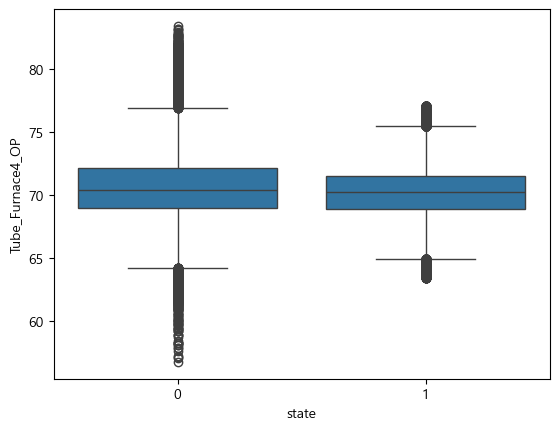

In [547]:
sns.boxplot(x= 'state', y = 'Tube_Furnace4_OP', data = df)

In [582]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace_CP값과 이상이 없을 경우의 Tube_Furnace_CP값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace_CP값과 이상이 없을 경우의 Tube_Furnace_CP값에는 평균에 차이가 있다
df1 = df[df['state']  == 0]['Tube_Furnace_CP']
df2 = df[df['state']  == 1]['Tube_Furnace_CP']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p}')
# p-value가 0.05보다 작으므로, 대립가설(차이가 있다)
# t 통계량이 음수이므로 Tube_Furnace_CP의 값이 클수록 이상발생 가능성이 크다

통계량 : 632342.69
p-value : 0.0
2 Sample ttest
t통계량 : -59.695
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace_CP'>

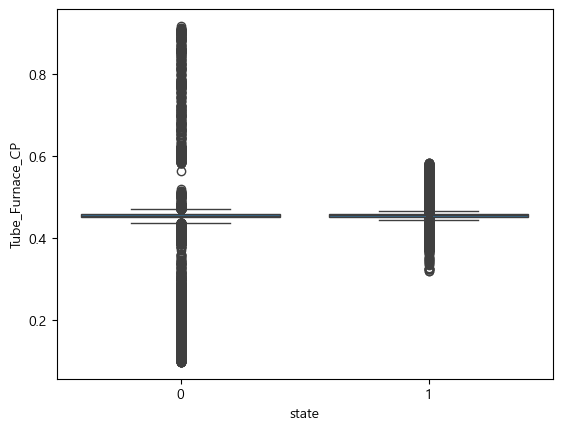

In [552]:
sns.boxplot(x= 'state', y = 'Tube_Furnace_CP', data = df)

In [558]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace1_Temp값과 이상이 없을 경우의 Tube_Furnace1_Temp값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace1_Temp값과 이상이 없을 경우의 Tube_Furnace1_Temp값에는 평균에 차이가 있다
df1 = df[df['state']  == 0]['Tube_Furnace1_Temp']
df2 = df[df['state']  == 1]['Tube_Furnace1_Temp']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p.round(3)}')
# p-value가 0.05보다 크므로, 귀무가설(차이가 없다)
# t 통계량이 양수이므로 Tube_Furnace1_Temp의 값이 작을수록 이상발생 가능성이 크다

통계량 : 93.295
p-value : 0.0
2 Sample ttest
t통계량 : 15.068
p-value : 0.0


<Axes: xlabel='state', ylabel='Tube_Furnace1_Temp'>

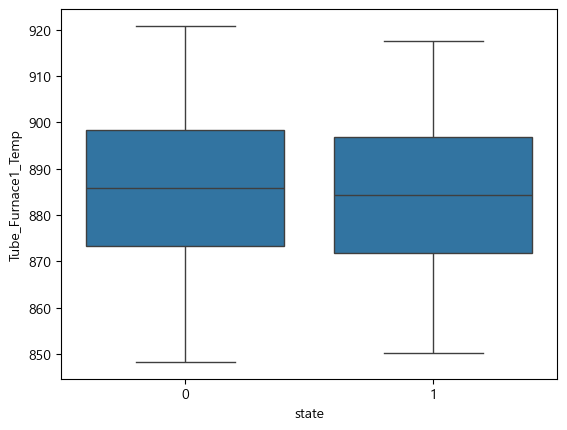

In [560]:
sns.boxplot(x= 'state', y = 'Tube_Furnace1_Temp', data = df)

In [562]:
# 귀무가설 : 이상이 발생했을 경우의 Tube_Furnace2_Temp값과 이상이 없을 경우의 Tube_Furnace2_Temp값에는 평균에 차이가 없다
# 대립가설 : 이상이 발생했을 경우의 Tube_Furnace2_Temp값과 이상이 없을 경우의 Tube_Furnace2_Temp값에는 평균에 차이가 있다
df1 = df[df['state']  == 0]['Tube_Furnace2_Temp']
df2 = df[df['state']  == 1]['Tube_Furnace2_Temp']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p.round(3)}')
# p-value가 0.05보다 크므로, 귀무가설(차이가 없다)
# t 통계량이 음수이므로 Tube_Furnace1_Temp의 값이 클수록 이상발생 가능성이 크다

통계량 : 0.001
p-value : 0.973
2 Sample ttest
t통계량 : -0.015
p-value : 0.988


<Axes: xlabel='state', ylabel='Tube_Furnace2_Temp'>

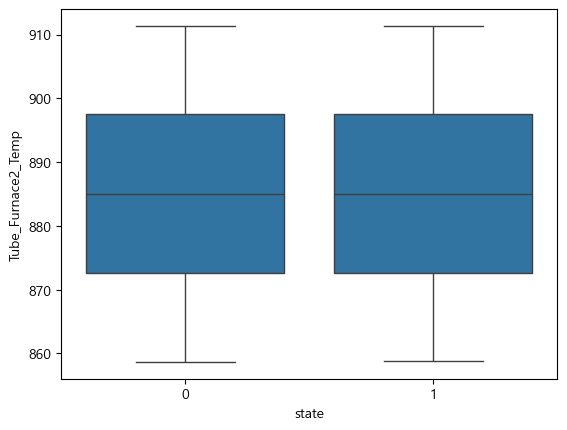

In [566]:
sns.boxplot(x= 'state', y = 'Tube_Furnace2_Temp', data = df)

In [569]:
df1 = df[df['state']  == 0]['Tube_Furnace3_Temp']
df2 = df[df['state']  == 1]['Tube_Furnace3_Temp']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p.round(3)}')

통계량 : 0.054
p-value : 0.817
2 Sample ttest
t통계량 : 1.372
p-value : 0.17


<Axes: xlabel='state', ylabel='Tube_Furnace3_Temp'>

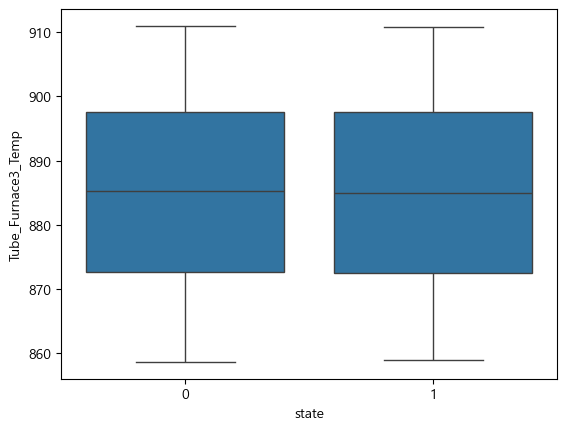

In [571]:
sns.boxplot(x= 'state', y = 'Tube_Furnace3_Temp', data = df)

In [573]:
df1 = df[df['state']  == 0]['Tube_Furnace4_Temp']
df2 = df[df['state']  == 1]['Tube_Furnace4_Temp']
# ttest를 위한 등분상성 검정
stats, p = bartlett(df1, df2)
print(f'통계량 : {stats.round(3)}')
print(f'p-value : {p.round(3)}')
# 2 sample Ttest
t_result = ttest_ind(df1,df2  , equal_var = False)
t , p = t_result.statistic.round(3), t_result.pvalue
print('2 Sample ttest')
print(f"t통계량 : {t}")
print(f'p-value : {p.round(3)}')

통계량 : 0.0
p-value : 0.995
2 Sample ttest
t통계량 : -1.228
p-value : 0.219


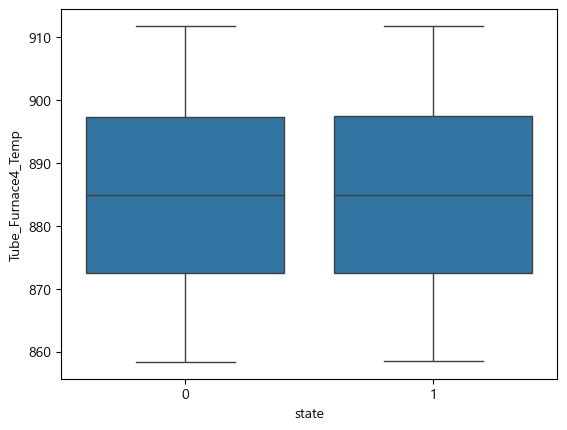

In [577]:
sns.boxplot(x= 'state', y = 'Tube_Furnace4_Temp', data = df);